In [18]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("dataSet").getOrCreate()
file = "heart_2020_cleaned.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

In [19]:
columns_to_drop = ["Race", "MentalHealth", "PhysicalHealth"]
df = df.drop(*columns_to_drop)

df.printSchema()

root
 |-- HeartDisease: string (nullable = true)
 |-- BMI: double (nullable = true)
 |-- Smoking: string (nullable = true)
 |-- AlcoholDrinking: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- DiffWalking: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- AgeCategory: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- PhysicalActivity: string (nullable = true)
 |-- GenHealth: string (nullable = true)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: string (nullable = true)
 |-- KidneyDisease: string (nullable = true)
 |-- SkinCancer: string (nullable = true)



In [9]:
column_name = "BMI"
description = df.describe(column_name)

description.show()

+-------+------------------+
|summary|               BMI|
+-------+------------------+
|  count|            319795|
|   mean|28.325398520925823|
| stddev| 6.356100200470757|
|    min|             12.02|
|    max|             94.85|
+-------+------------------+



In [10]:
column_name = "SleepTime"
description = df.describe(column_name)

description.show()

+-------+------------------+
|summary|         SleepTime|
+-------+------------------+
|  count|            319795|
|   mean| 7.097074688472302|
| stddev|1.4360070609642777|
|    min|                 1|
|    max|                24|
+-------+------------------+



In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import stddev, mean, abs, col


bmi_stats = df.select(mean(col("BMI")).alias("mean_BMI"), stddev(col("BMI")).alias("stddev_BMI")).first()
mean_bmi = bmi_stats["mean_BMI"]
stddev_bmi = bmi_stats["stddev_BMI"]


sleep_time_stats = df.select(mean(col("SleepTime")).alias("mean_SleepTime"), stddev(col("SleepTime")).alias("stddev_SleepTime")).first()
mean_sleep_time = sleep_time_stats["mean_SleepTime"]
stddev_sleep_time = sleep_time_stats["stddev_SleepTime"]


threshold = 3


df = df.withColumn("z_score_BMI", abs((col("BMI") - mean_bmi) / stddev_bmi))
df = df.withColumn("z_score_SleepTime", abs((col("SleepTime") - mean_sleep_time) / stddev_sleep_time))

df = df.filter(col("z_score_BMI") <= threshold)


df = df.filter(col("z_score_SleepTime") <= threshold)


df = df.drop("z_score_BMI", "z_score_SleepTime")


df.show()

+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|   Sex|AgeCategory|            Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|
+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+
|          No| 16.6|    Yes|             No|    No|         No|Female|      55-59|                 Yes|             Yes|Very good|        5|   Yes|           No|       Yes|
|          No|20.34|     No|             No|   Yes|         No|Female|80 or older|                  No|             Yes|Very good|        7|    No|           No|        No|
|          No|26.58|    Yes|             No|    No|         No|  Male|      65-69|                 Yes|             Yes|     Fair|     

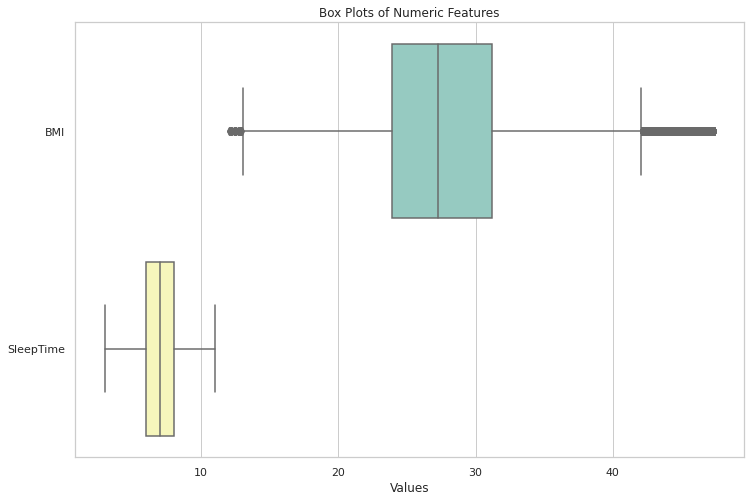

In [4]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pandas_df = df.toPandas()

plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.boxplot(data=pandas_df, palette="Set3", orient="h")
plt.title('Box Plots of Numeric Features')
plt.xlabel('Values')

plt.show()

In [21]:
df = df.dropna()


numeric_features=['BMI', 'SleepTime']
categorical_features=['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Diabetic', 'PhysicalActivity', 'GenHealth','Asthma', 'KidneyDisease', 'SkinCancer']
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c + "_null_count") for c in categorical_features+numeric_features])
null_counts.show()

+-----------------------+------------------+--------------------------+-----------------+----------------------+--------------+----------------------+-------------------+---------------------------+--------------------+-----------------+------------------------+---------------------+--------------+--------------------+
|HeartDisease_null_count|Smoking_null_count|AlcoholDrinking_null_count|Stroke_null_count|DiffWalking_null_count|Sex_null_count|AgeCategory_null_count|Diabetic_null_count|PhysicalActivity_null_count|GenHealth_null_count|Asthma_null_count|KidneyDisease_null_count|SkinCancer_null_count|BMI_null_count|SleepTime_null_count|
+-----------------------+------------------+--------------------------+-----------------+----------------------+--------------+----------------------+-------------------+---------------------------+--------------------+-----------------+------------------------+---------------------+--------------+--------------------+
|                      0|            

In [23]:
from pyspark.sql import functions as F

df = df.withColumn(
    'BMI_Category',
    F.when((df['BMI'] < 18.5), 'Low')
    .when((df['BMI'] >= 18.5) & (df['BMI'] < 24.9), 'Normal')
    .when((df['BMI'] >= 25.0) & (df['BMI'] < 29.9), 'Over')
    .when((df['BMI'] >= 30.0) & (df['BMI'] < 34.9), 'ObeseI')
    .when((df['BMI'] >= 35.0) & (df['BMI'] < 39.9), 'ObesityII')
    .otherwise('ObesityIII')
)

df.show()


+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+------------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|   Sex|AgeCategory|            Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|BMI_Category|
+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+------------+
|          No| 16.6|    Yes|             No|    No|         No|Female|      55-59|                 Yes|             Yes|Very good|        5|   Yes|           No|       Yes|         Low|
|          No|20.34|     No|             No|   Yes|         No|Female|80 or older|                  No|             Yes|Very good|        7|    No|           No|        No|      Normal|
|          No|26.58|    Yes|             No|    No|         No|  Male|

In [36]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("dataSet").getOrCreate()
file = "heart_2020_cleaned.csv"
df = spark.read.csv(file, header=True, inferSchema=True)

columns_to_drop = ["Race", "MentalHealth", "PhysicalHealth"]
df = df.drop(*columns_to_drop)

from pyspark.sql.functions import stddev, mean, abs, col
bmi_stats = df.select(mean(col("BMI")).alias("mean_BMI"), stddev(col("BMI")).alias("stddev_BMI")).first()
mean_bmi = bmi_stats["mean_BMI"]
stddev_bmi = bmi_stats["stddev_BMI"]
sleep_time_stats = df.select(mean(col("SleepTime")).alias("mean_SleepTime"), stddev(col("SleepTime")).alias("stddev_SleepTime")).first()
mean_sleep_time = sleep_time_stats["mean_SleepTime"]
stddev_sleep_time = sleep_time_stats["stddev_SleepTime"]
threshold = 3
df = df.withColumn("z_score_BMI", abs((col("BMI") - mean_bmi) / stddev_bmi))
df = df.withColumn("z_score_SleepTime", abs((col("SleepTime") - mean_sleep_time) / stddev_sleep_time))
df = df.filter(col("z_score_BMI") <= threshold)
df = df.filter(col("z_score_SleepTime") <= threshold)
df = df.drop("z_score_BMI", "z_score_SleepTime")

df = df.dropna()

from pyspark.sql import functions as F

df = df.withColumn(
    'BMI_Category',
    F.when((df['BMI'] < 18.5), 'Low')
    .when((df['BMI'] >= 18.5) & (df['BMI'] < 24.9), 'Normal')
    .when((df['BMI'] >= 25.0) & (df['BMI'] < 29.9), 'Over')
    .when((df['BMI'] >= 30.0) & (df['BMI'] < 34.9), 'ObeseI')
    .when((df['BMI'] >= 35.0) & (df['BMI'] < 39.9), 'ObesityII')
    .otherwise('ObesityIII')
)

df.show()

+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+------------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|   Sex|AgeCategory|            Diabetic|PhysicalActivity|GenHealth|SleepTime|Asthma|KidneyDisease|SkinCancer|BMI_Category|
+------------+-----+-------+---------------+------+-----------+------+-----------+--------------------+----------------+---------+---------+------+-------------+----------+------------+
|          No| 16.6|    Yes|             No|    No|         No|Female|      55-59|                 Yes|             Yes|Very good|        5|   Yes|           No|       Yes|         Low|
|          No|20.34|     No|             No|   Yes|         No|Female|80 or older|                  No|             Yes|Very good|        7|    No|           No|        No|      Normal|
|          No|26.58|    Yes|             No|    No|         No|  Male|

In [37]:
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

binary_features = ["HeartDisease", "AlcoholDrinking", "Stroke", "DiffWalking", "Smoking", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]

for column in binary_features:
    df = df.withColumn(column, F.when(df[column] == 'Yes', 1).otherwise(0))

df = df.withColumn("Sex", F.when(df["Sex"] == "Male", 1).otherwise(0))

df = df.withColumn("Diabetic", F.when(df["Diabetic"] == "No, borderline diabetes", 0).when(df["Diabetic"] == "Yes (during pregnancy)", 1).otherwise(df["Diabetic"]))

indexer1 = StringIndexer(inputCol="BMI_Category", outputCol="BMI_CategoryIndex")
indexer2 = StringIndexer(inputCol="AgeCategory", outputCol="AgeCategoryIndex")
indexer3 = StringIndexer(inputCol="GenHealth", outputCol="GenHealthIndex")

encoder1 = OneHotEncoder(inputCol="BMI_CategoryIndex", outputCol="BMI_CategoryVec")
encoder2 = OneHotEncoder(inputCol="AgeCategoryIndex", outputCol="AgeCategoryVec")
encoder3 = OneHotEncoder(inputCol="GenHealthIndex", outputCol="GenHealthVec")

pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, encoder1, encoder2, encoder3])

model = pipeline.fit(df)
df_transformed = model.transform(df)

df = df_transformed.drop("BMI_Category", "AgeCategory", "GenHealth")


df.show()

+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+-----------------+----------------+--------------+---------------+--------------+-------------+
|HeartDisease|  BMI|Smoking|AlcoholDrinking|Stroke|DiffWalking|Sex|Diabetic|PhysicalActivity|SleepTime|Asthma|KidneyDisease|SkinCancer|BMI_CategoryIndex|AgeCategoryIndex|GenHealthIndex|BMI_CategoryVec|AgeCategoryVec| GenHealthVec|
+------------+-----+-------+---------------+------+-----------+---+--------+----------------+---------+------+-------------+----------+-----------------+----------------+--------------+---------------+--------------+-------------+
|           0| 16.6|      1|              0|     0|          0|  0|       1|               1|        5|     1|            0|         1|              5.0|             3.0|           0.0|      (5,[],[])|(12,[3],[1.0])|(4,[0],[1.0])|
|           0|20.34|      0|              0|     1|          0|  0|       0|

In [31]:
df.printSchema()

root
 |-- HeartDisease: integer (nullable = false)
 |-- BMI: double (nullable = true)
 |-- Smoking: integer (nullable = false)
 |-- AlcoholDrinking: integer (nullable = false)
 |-- Stroke: integer (nullable = false)
 |-- DiffWalking: integer (nullable = false)
 |-- Sex: integer (nullable = false)
 |-- Diabetic: integer (nullable = false)
 |-- PhysicalActivity: integer (nullable = false)
 |-- SleepTime: integer (nullable = true)
 |-- Asthma: integer (nullable = false)
 |-- KidneyDisease: integer (nullable = false)
 |-- SkinCancer: integer (nullable = false)
 |-- BMI_CategoryIndex: double (nullable = false)
 |-- AgeCategoryIndex: double (nullable = false)
 |-- GenHealthIndex: double (nullable = false)
 |-- BMI_CategoryVec: vector (nullable = true)
 |-- AgeCategoryVec: vector (nullable = true)
 |-- GenHealthVec: vector (nullable = true)

